In [1]:
import jax 
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(4)

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

import sys
sys.path.append('..')
from ukraine_sentiment.graphing import config_matplotlib
config_matplotlib()

# Model Setup

Consider a fully-connected network -- regions in a country. Information travels instantaneously through the network according to edge weights, given in an attention matrix $A$, with elements: $a_{i,j} \in [0, 1]$ and $a_{i,i} = 1$. That is, regions always pay attention to themselves, and pay attention to other regions with some scaling factor.

The country is at war, and attacks occur at nodes in the network. These attacks cause fear throughout the network. Call the impact on fear of an attack $\epsilon_t$. The effect on any location in the network will be $R\epsilon_t$, because information about the attack travels instantly. Fear will increase all throughout the network, but unevenly, since not all nodes pay the same amount of attention to the attacked node.

Attacks do not occur every period. Define an indicator variable $\varphi_t$ that takes a value of 1 if an attack occurs, and 0 otherwise.

Assume that the fear signal is imperfectly observed, so that there is also some i.i.d white noise, $\eta_t$. 

Finally, assume that fear within a region lingers for some time, independently of any other region. The degree of lingering will be $\Gamma$, with $\gamma_{i,i} \in [0, 1)$ and $\gamma_{i,j} = 0$.

$$x_{t+1} = \Gamma x_t + \varphi_tR\epsilon_t + \eta_t$$

with
$$\begin{align} \epsilon_t & \sim N(0, Q) \\
                    \eta_t & \sim N(0, \Sigma) \end{align}$$
                    
The attention matrix $R$ can be brought into the covariance of $\epsilon$; define $nu_t \sim N(0, RQR^T)$, then:

$$x_{t+1} = \Gamma x_t + \varphi_t \nu_t + \eta_t$$

Also I guess $\Sigma$ should be diagonal.

In [39]:
from scipy.special import expit
n_regions = 5
T = 50

rng = np.random.default_rng(sum(map(ord, 'VAR test')))

true_Γ = np.diag(expit(rng.normal(scale=3, size=n_regions)))
true_R = expit(rng.normal(scale=3, size=((n_regions, n_regions))))
true_R[np.diag_indices_from(true_R)] = 1

true_Σ = np.diag(rng.gamma(2, 1, size=(n_regions)))
true_obs_Σ = np.diag(rng.gamma(2, 1, size=(n_regions)))
Q_chol_pt, *_ = pm.LKJCholeskyCov.dist(n=n_regions, sd_dist=pm.Gamma.dist(alpha=2, beta=0.5), eta=1)
true_Q = pm.draw(Q_chol_pt @ Q_chol_pt.T)

true_intercept = rng.normal(loc=-2, scale=1, size=n_regions)

true_p_attack = rng.uniform(0, 1, size=n_regions)
attack_data = rng.binomial(1, true_p_attack, size=(T, n_regions))

data = np.zeros((T, n_regions, 1))
observed = np.zeros((T, n_regions, 1))

data[0, ...] = rng.normal(loc=-2, scale=2, size=(n_regions, 1))

for t in range(T-1):
#     nu = rng.multivariate_normal(mean=np.zeros(n_regions), cov= true_R @ true_Q @ true_R.T)
#     eta = rng.multivariate_normal(mean=np.zeros(n_regions), cov=true_Σ)
    obs_noise = rng.multivariate_normal(mean=np.zeros(n_regions), cov=true_obs_Σ)
    
    R_attack = np.diag(attack_data[t])    
    assert np.allclose(R_attack @ true_Σ, attack_data[t] * true_Σ)
    
    joint_cov = R_attack @ true_Σ + true_R @ true_Q @ true_R.T
    
    shock = rng.multivariate_normal(mean=np.zeros(n_regions), cov=joint_cov)
    data[t+1] = true_intercept[:, None] + true_Γ @ data[t, None] + shock[:, None]
    observed[t] = data[t] + obs_noise[:, None]
    
fear_index = expit(observed[..., 0]) * 100

<Axes: >

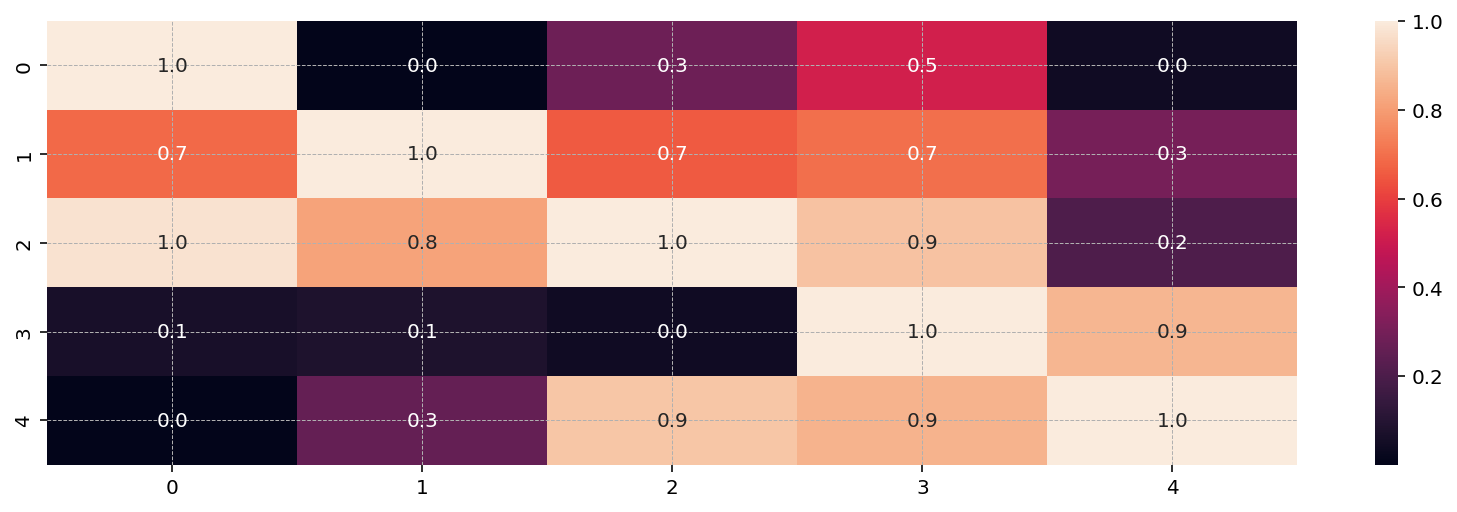

In [43]:
import seaborn as sns
sns.heatmap(true_R, annot=True, fmt='0.1f')

In [41]:
from scipy.special import logit
np.allclose(logit(fear_index / 100), observed[..., 0])

True

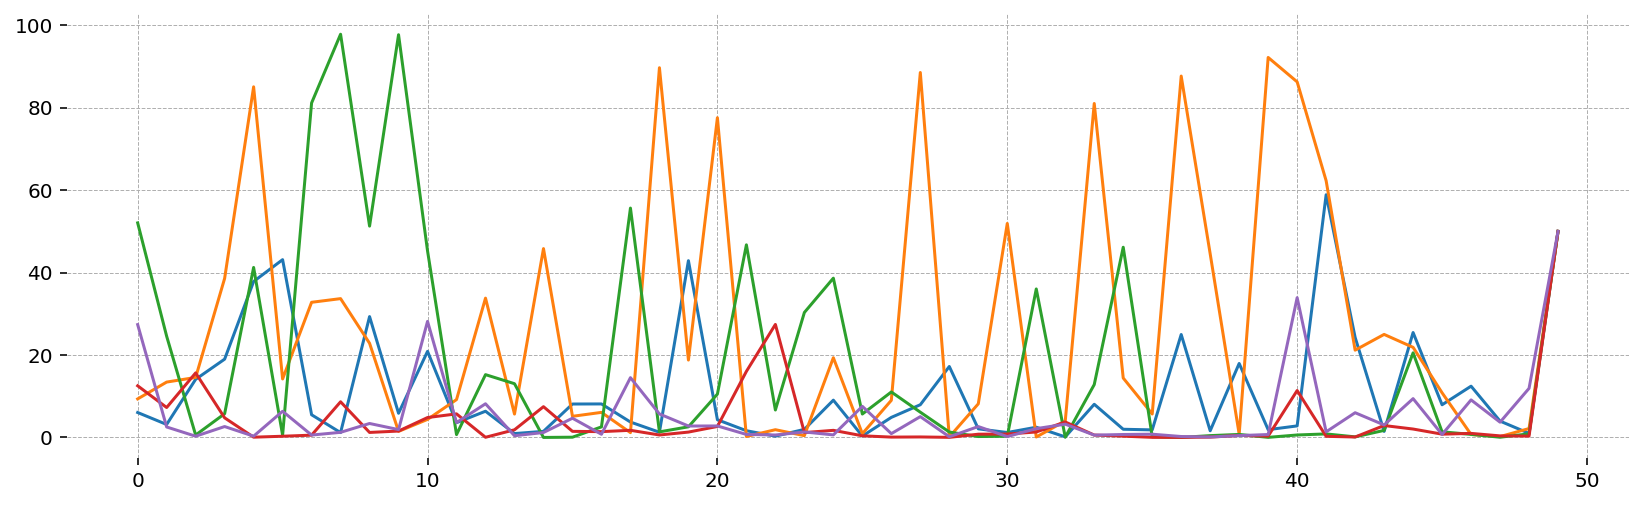

In [42]:
plt.plot(fear_index);

## Parameter Recovery

In [44]:
from pytensor.link.jax.dispatch import jax_funcify
from pytensor.tensor.basic import Tri
import jax.numpy as jnp
from pytensor.graph.basic import Constant

@jax_funcify.register(Tri)
def jax_funcify_Tri(op, node, **kwargs):
    tri_args = node.inputs
    constant_args = []
    for arg in tri_args:
        if not isinstance(arg, Constant):
            raise NotImplementedError(f'The argument {arg} to Tri is not constant and cannot be converted to JAX')

        constant_args.append(arg.value)

    M, N, K = constant_args
    def tri(*_):
        return jnp.tri(N, M, k)

    return tri

In [47]:
import statsmodels.api as sm
mod = sm.tsa.VARMAX(observed[..., 0], order=(1, 0), measurement_error=True, error_cov_type='diagonal')
res = mod.fit(disp=0, maxiter=1000)

/home/jesse/mambaforge/envs/ukraine-sentiment/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [88]:
from pytensor.compile.mode import get_mode
from pymc.pytensorf import collect_default_updates

k = n_regions * (n_regions - 1)

with pm.Model(check_bounds=False) as model:    
    attack_pt = pm.ConstantData('attacks', attack_data)
    obs_pt = pm.ConstantData('observed_data', observed[..., 0])
    
    gamma_mu = pm.Normal('mu_gamma', mu=-3, sigma=1)
    gamma_sigma = pm.Gamma('sigma_gamma', alpha=2, beta=1)
    gamma_offset = pm.Normal('gamma_offset', size=n_regions)
    
#     logit_gammas = pm.Normal('logit_gamma', mu=gamma_mu, sigma=gamma_sigma, size=n_regions)
    logit_gammas = pm.Deterministic('logit_gammas', gamma_mu + gamma_sigma * gamma_offset)
    gammas = pm.Deterministic('gamma', pm.math.invlogit(logit_gammas))
    
    r_mu = pm.Normal('r_mu', mu=0, sigma=1)
    r_sigma = pm.Gamma('r_sigma', alpha=2, beta=1)
    r_offset = pm.Normal('r_offset', size=k)
    logit_r_offdiag = pm.Deterministic('logit_r_offidag', r_mu + r_sigma * r_offset)
    r_offdiag = pm.Deterministic('r_offdiag', pm.math.invlogit(logit_r_offdiag))
    
    x0 = pm.Normal('x0', size=n_regions)
    
    R = pt.eye(n_regions)
    R = pt.set_subtensor(R[np.triu_indices(n_regions, 1)], r_offdiag[:k // 2])
    R = pt.set_subtensor(R[np.tril_indices(n_regions, -1)], r_offdiag[k // 2:])
    R = pt.specify_shape(R, (n_regions, n_regions))
    
    Γ = pt.diag(gammas)
    Γ = pt.specify_shape(Γ, (n_regions, n_regions))
    
    Q_chol, *_ = pm.LKJCholeskyCov('Q_chol', sd_dist=pm.Gamma.dist(alpha=2, beta=1), n=n_regions, eta=1)
    Q_chol = pt.specify_shape(Q_chol, (n_regions, n_regions))
    Q = pm.Deterministic('Q', Q_chol @ Q_chol.T)
    
    RQRT = R @ Q @ R.T
    
    sigma_eta = pm.Gamma('sigma_eta', alpha=2, beta=1, size=n_regions)
    Σ = pt.diag(sigma_eta)
        
    def VAR_step(*args):
        attack, last_x, Γ, RQRT, Σ = args
        shock_cov = pt.diag(attack) @ Σ + RQRT
        x = pm.MvNormal.dist(mu=Γ @ last_x, tau=shock_cov)
        return x, collect_default_updates(args, [x])
        
    var_mean, updates = pytensor.scan(VAR_step, 
                                      sequences=attack_pt,
                                      outputs_info=[x0],
                                      non_sequences=[Γ, RQRT, Σ],
                                      strict=True,
                                      mode=get_mode("JAX"))
    
    model.register_rv(var_mean, name = 'VAR_mean', initval=pt.as_tensor_variable(res.states.smoothed))
    intercept = pm.Normal('intercept', size=n_regions)
    noise_sigmas = pm.Gamma('noise_sigmas', alpha=2, beta=1, size=n_regions)

    obs = pm.Normal('obs', mu = intercept + var_mean, sigma=noise_sigmas, observed=obs_pt)
    idata = pm.sample(nuts_sampler='numpyro', 
                      nuts_sampler_kwargs={'chain_method':'vectorized'},
                      tune=4000,
                      target_accept=0.95)
    print(f'Divergences: {idata.sample_stats.diverging.sum().values}')

/home/jesse/mambaforge/envs/ukraine-sentiment/lib/python3.11/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:06.052757
Sampling...


sample: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [33:26<00:00,  2.49it/s]


Sampling time =  0:33:27.864604
Transforming variables...
Transformation time =  0:00:00.104819
Divergences: 7


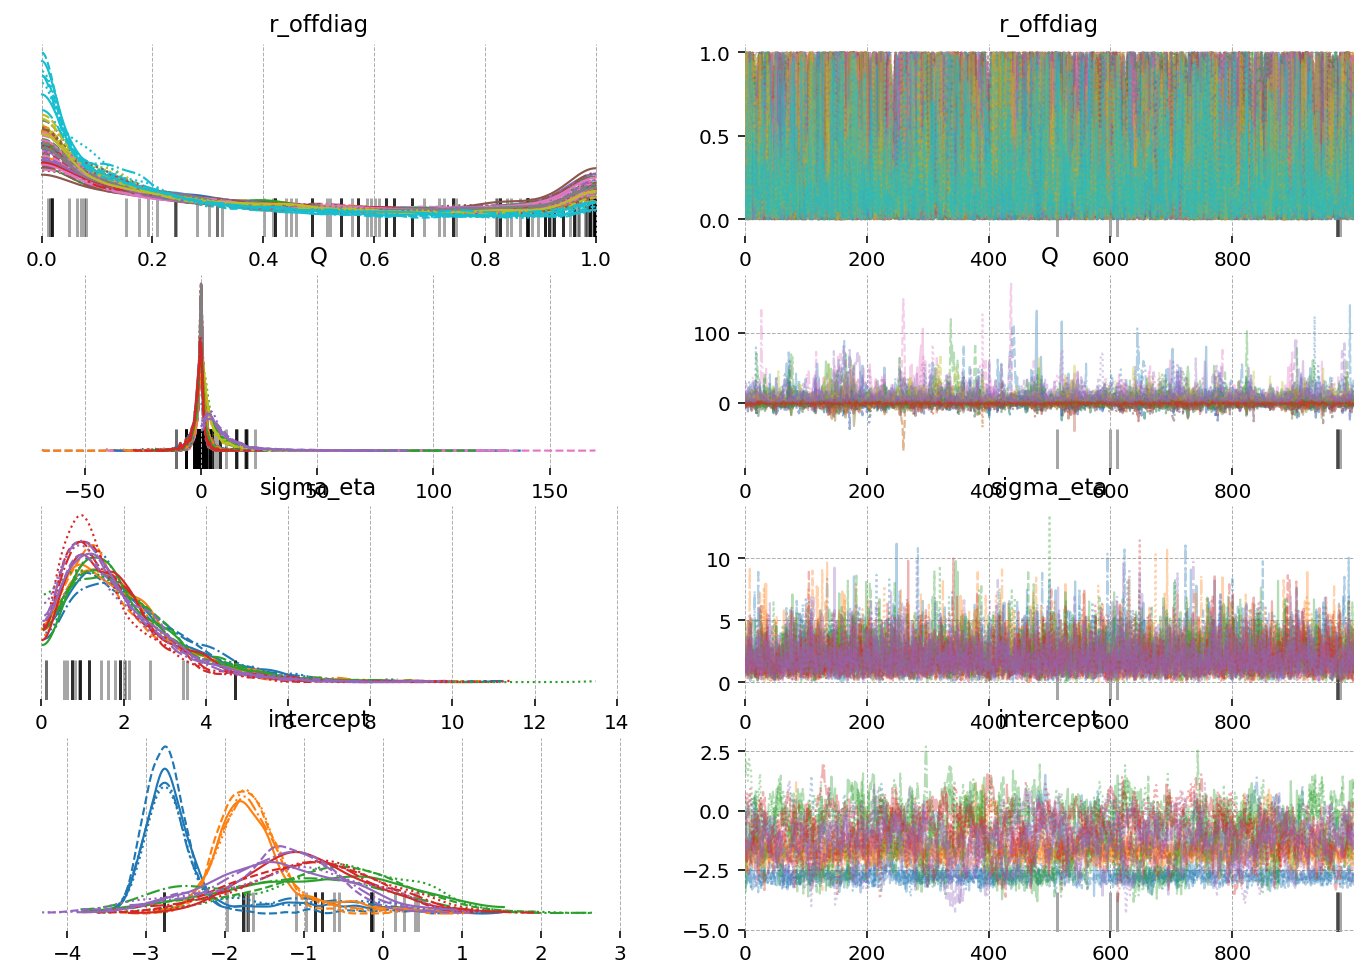

In [89]:
az.plot_trace(idata, var_names=['r_offdiag', 'Q', 'sigma_eta', 'intercept']);

<Axes: >

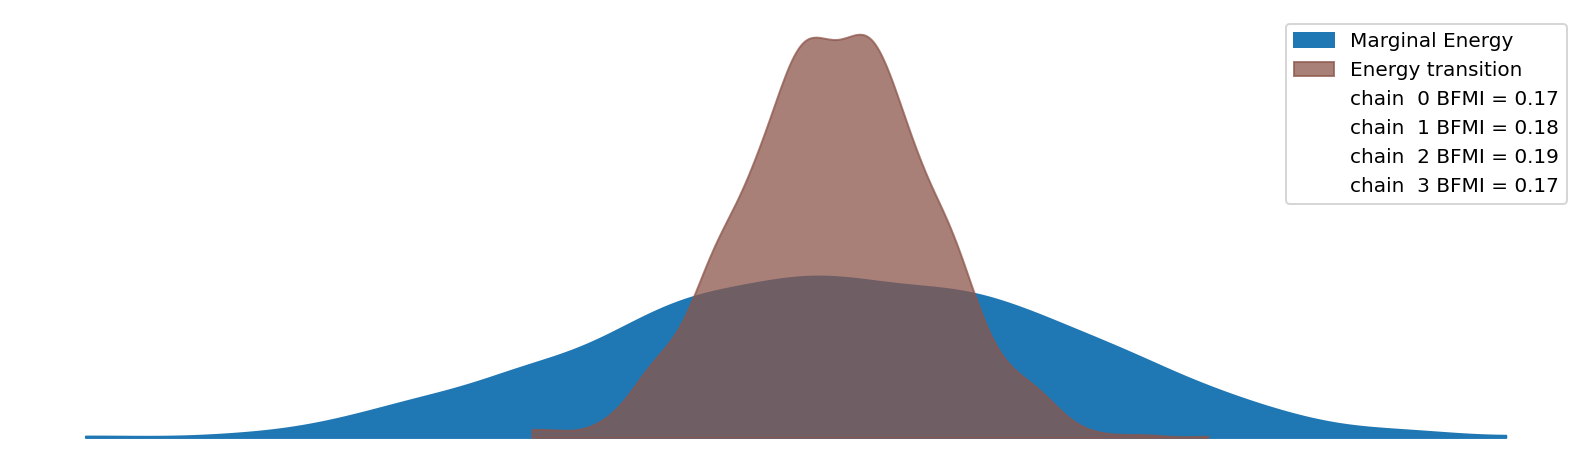

In [90]:
az.plot_energy(idata)

In [91]:
summary = az.summary(idata)

/home/jesse/mambaforge/envs/ukraine-sentiment/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [92]:
with model:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [obs]


In [93]:
preds = az.extract(idata, 'posterior_predictive').obs
hdi = az.hdi(idata.posterior_predictive.obs).obs

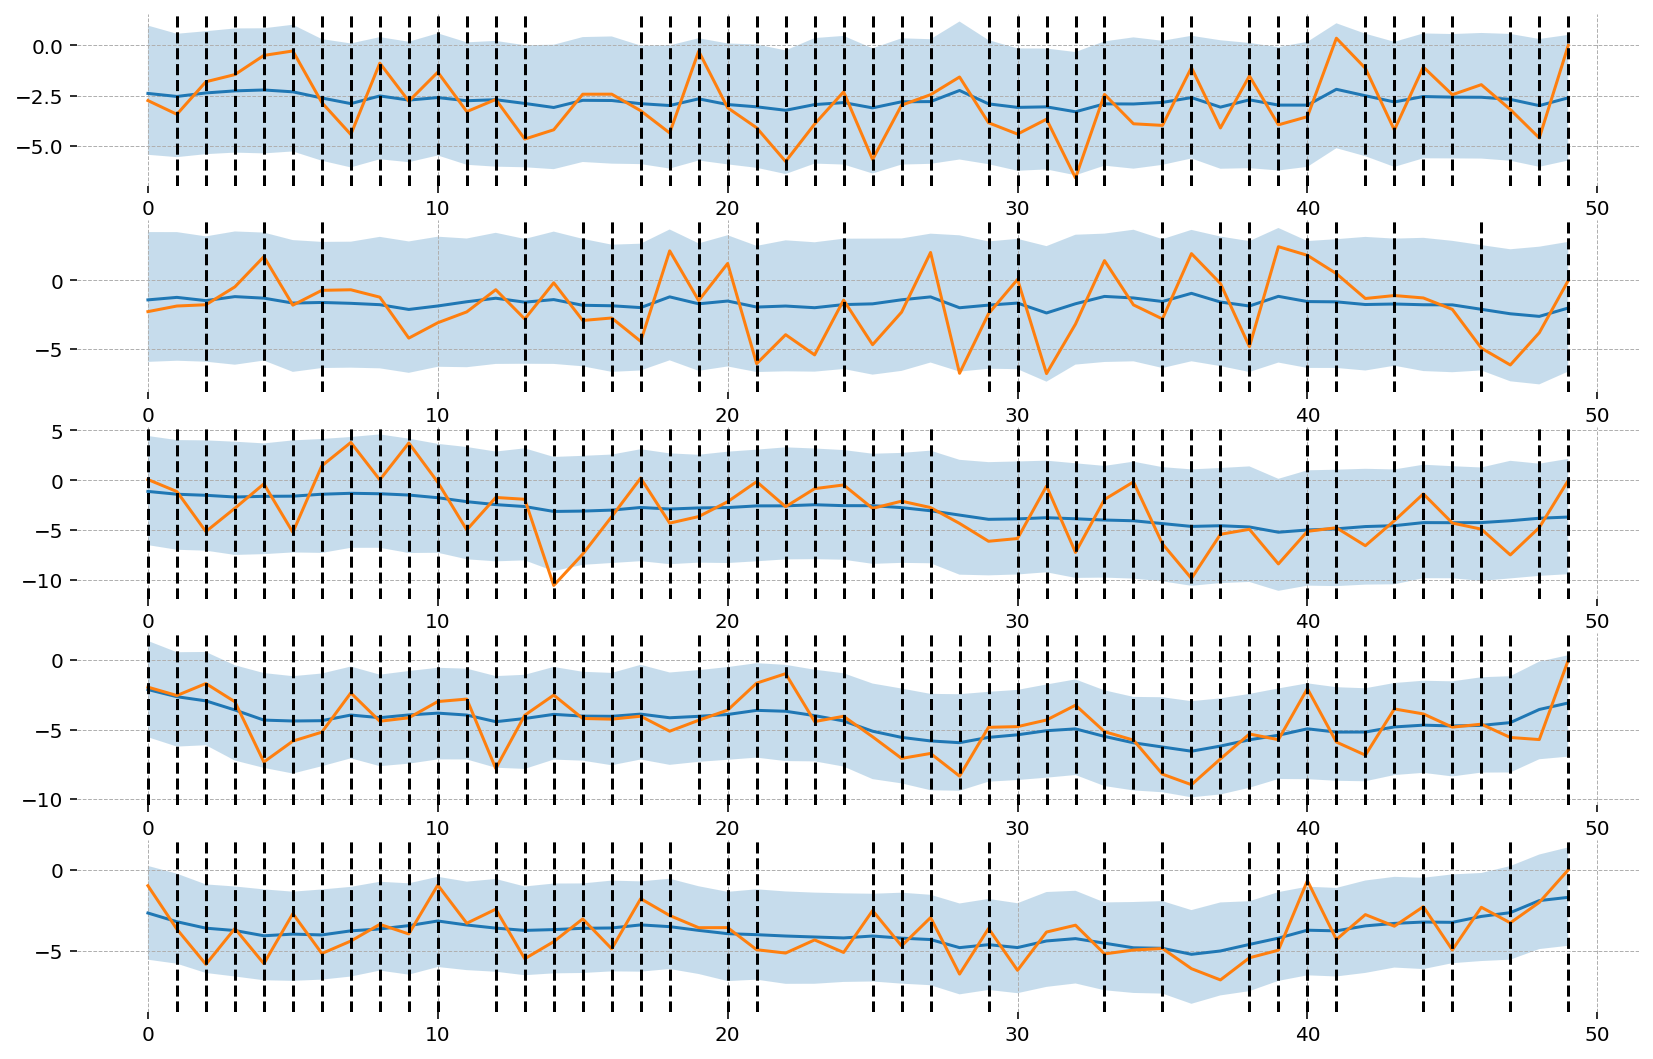

In [106]:
fig, ax = plt.subplots(n_regions, 1, figsize=(14, 9))
for i, axis in enumerate(fig.axes):
    axis.plot(preds.values.mean(axis=-1)[:, i])
    axis.fill_between(np.arange(T), *hdi.values[:, i, :].T, alpha=0.25)
    axis.plot(observed[:, i, 0])
    for t, attack in enumerate(attack_data[:, i]):
        if attack:
            axis.axvline(t, ls='--', color='k')

In [95]:
r_values = np.r_[true_R[np.triu_indices(n_regions, 1)], true_R[np.tril_indices(n_regions, -1)]]

In [96]:
R = np.eye(n_regions)
R[np.triu_indices(n_regions, 1)] = idata.posterior.r_offdiag.mean(dim=['chain', 'draw'])[:k // 2]
R[np.tril_indices(n_regions, -1)] = idata.posterior.r_offdiag.mean(dim=['chain', 'draw'])[k // 2:]

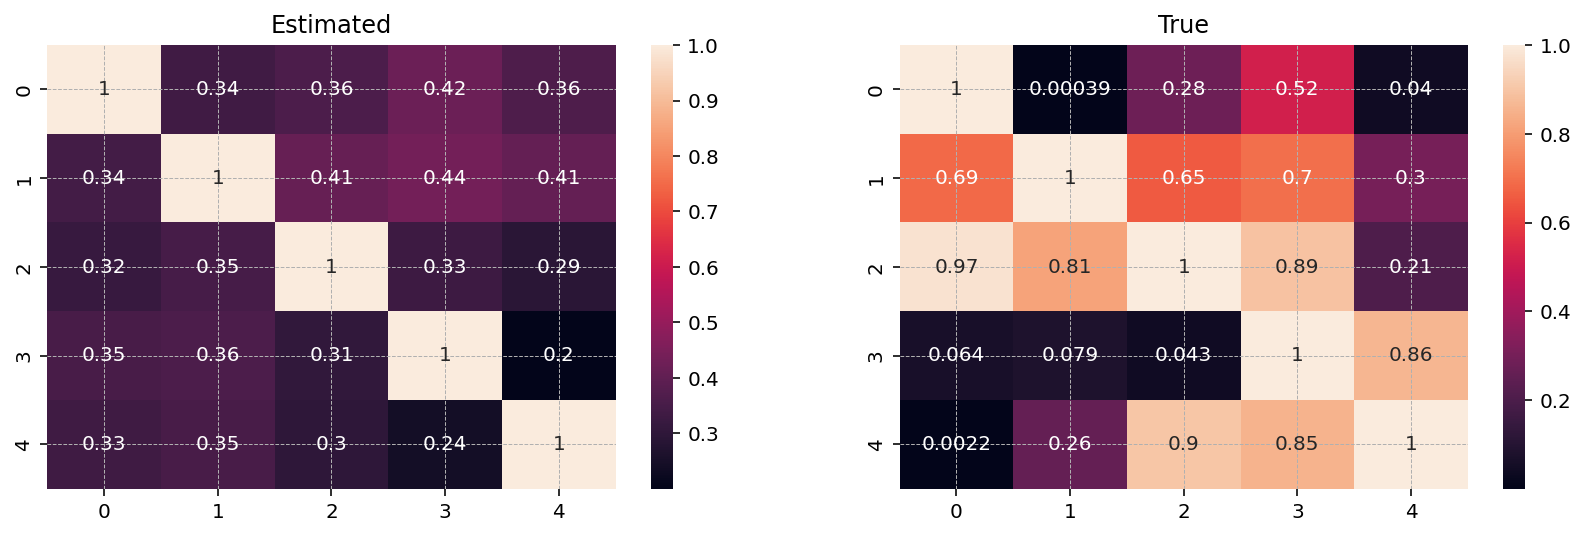

In [104]:
fig, ax = plt.subplots(1, 2)
sns.heatmap(R, ax=ax[0], annot=True)
sns.heatmap(true_R, ax=ax[1], annot=True)
ax[0].set_title('Estimated')
ax[1].set_title('True')
plt.show()

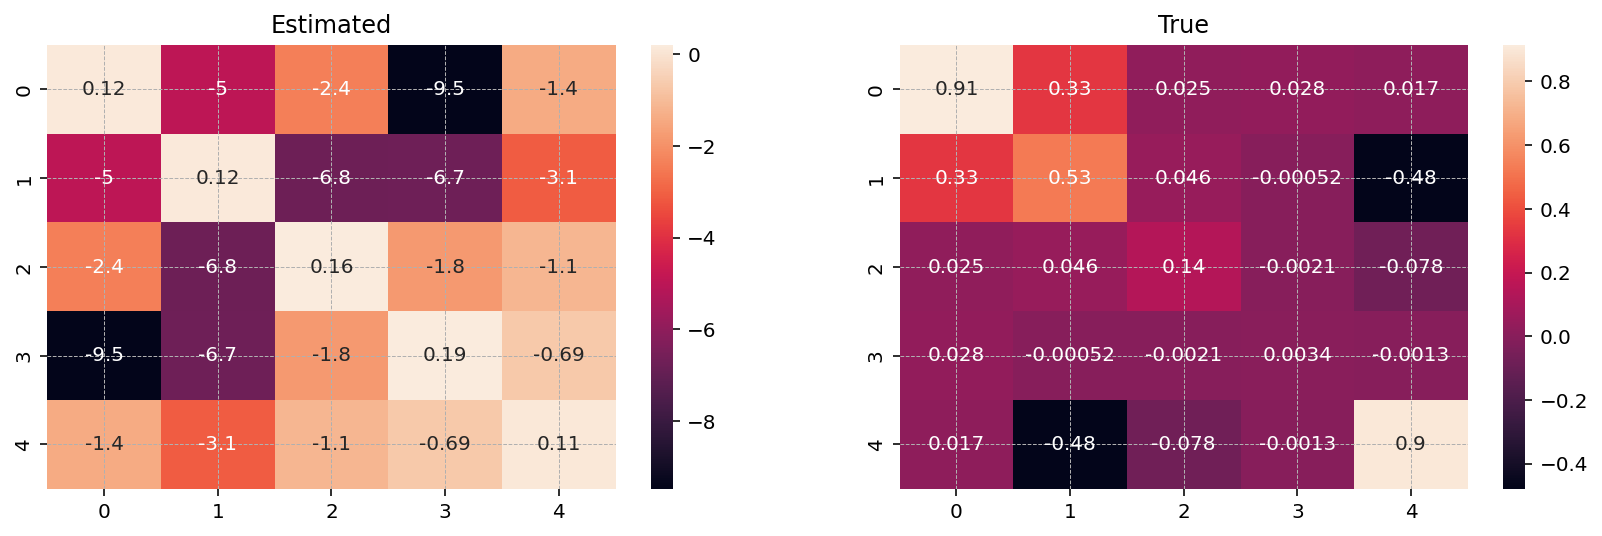

In [102]:
Q_post = idata.posterior.Q

fig, ax = plt.subplots(1, 2)
sns.heatmap(1/Q_post.mean(dim=['chain', 'draw']), ax=ax[0], annot=True)
sns.heatmap(true_Q, ax=ax[1], annot=True)
ax[0].set_title('Estimated')
ax[1].set_title('True')
plt.show()

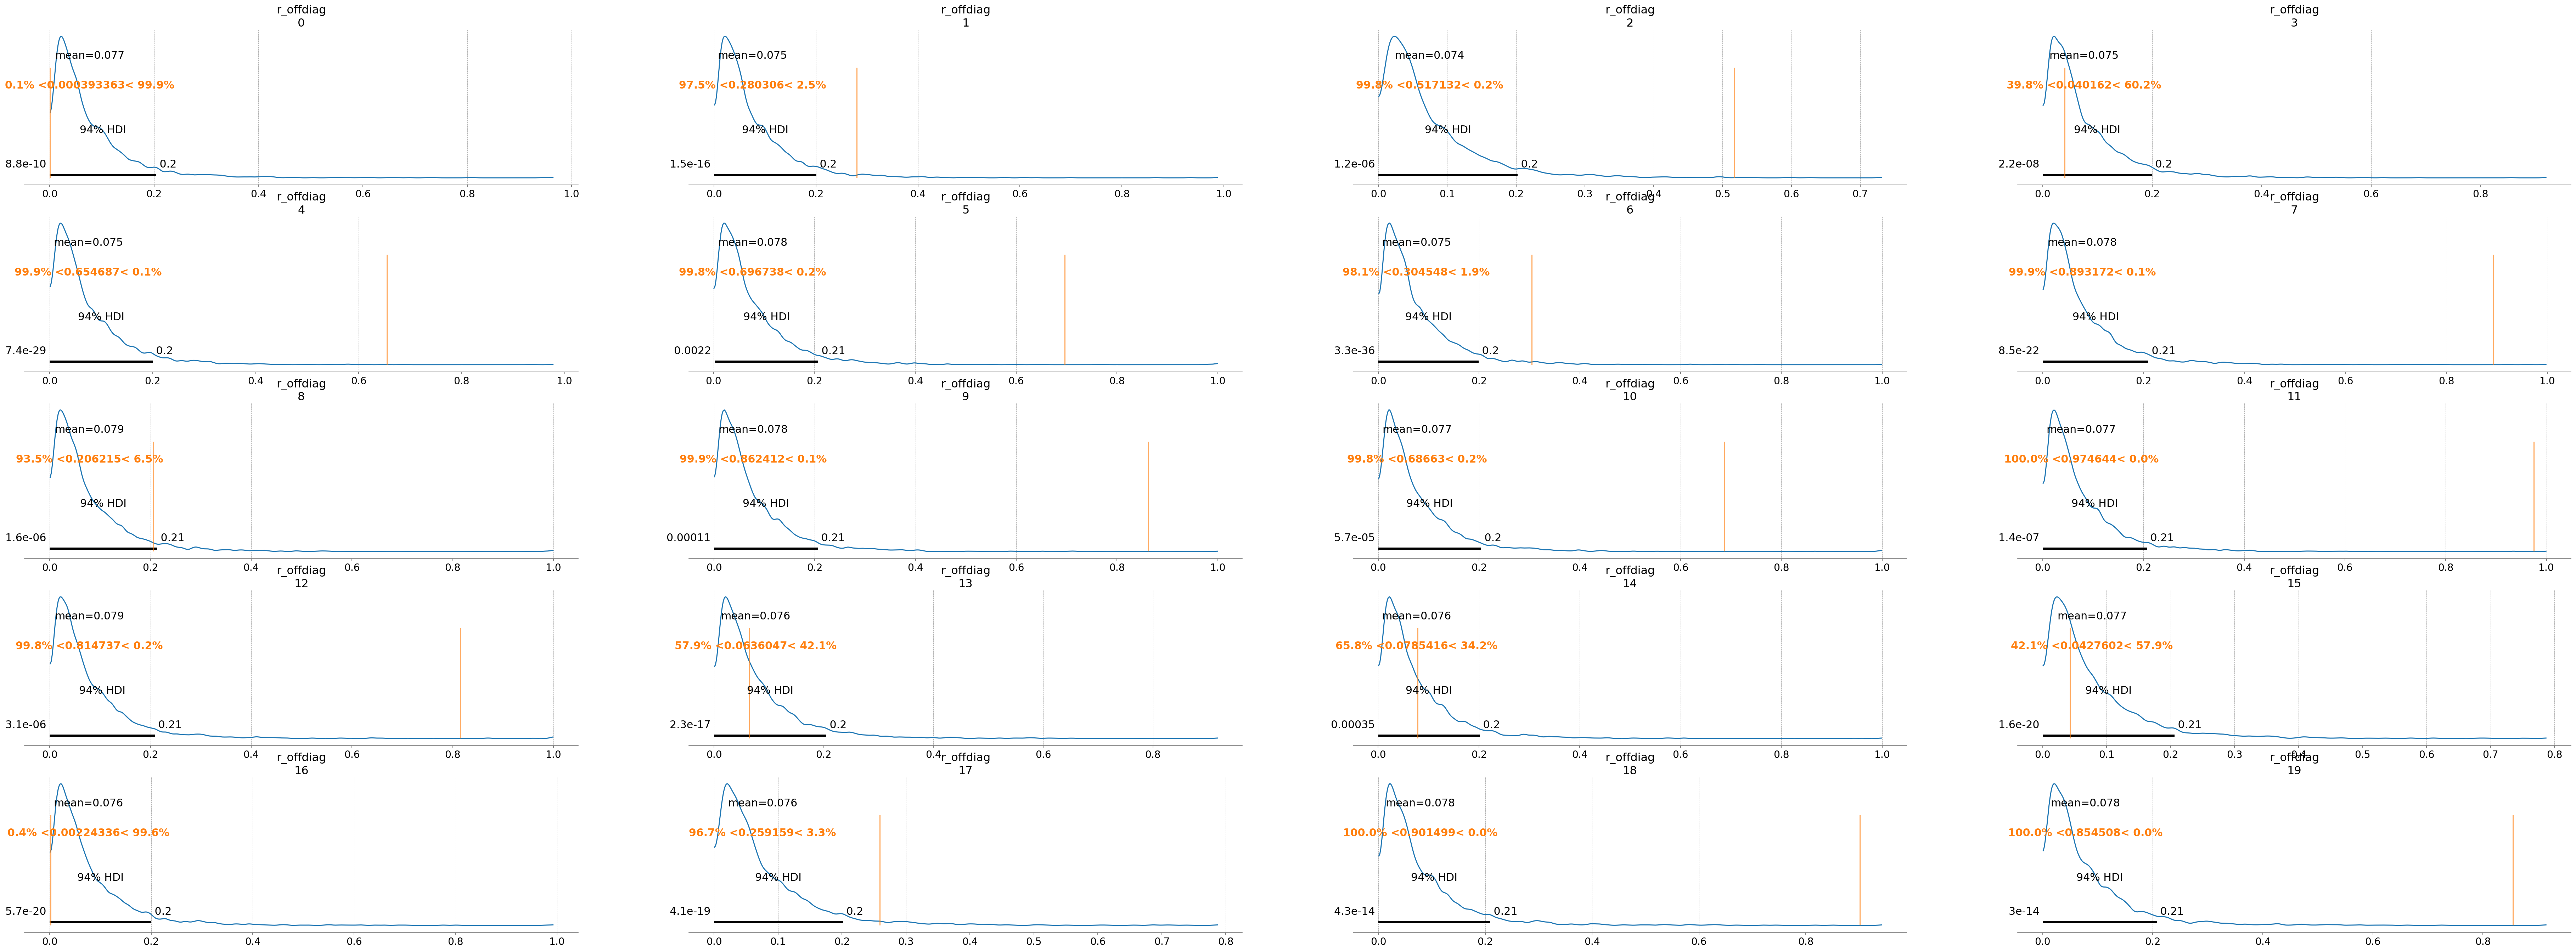

In [68]:
axes = az.plot_posterior(idata, var_names=['r_offdiag'], ref_val=r_values.tolist())
# az.plot_posterior(priors, var_names=['r_offdiag'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k')

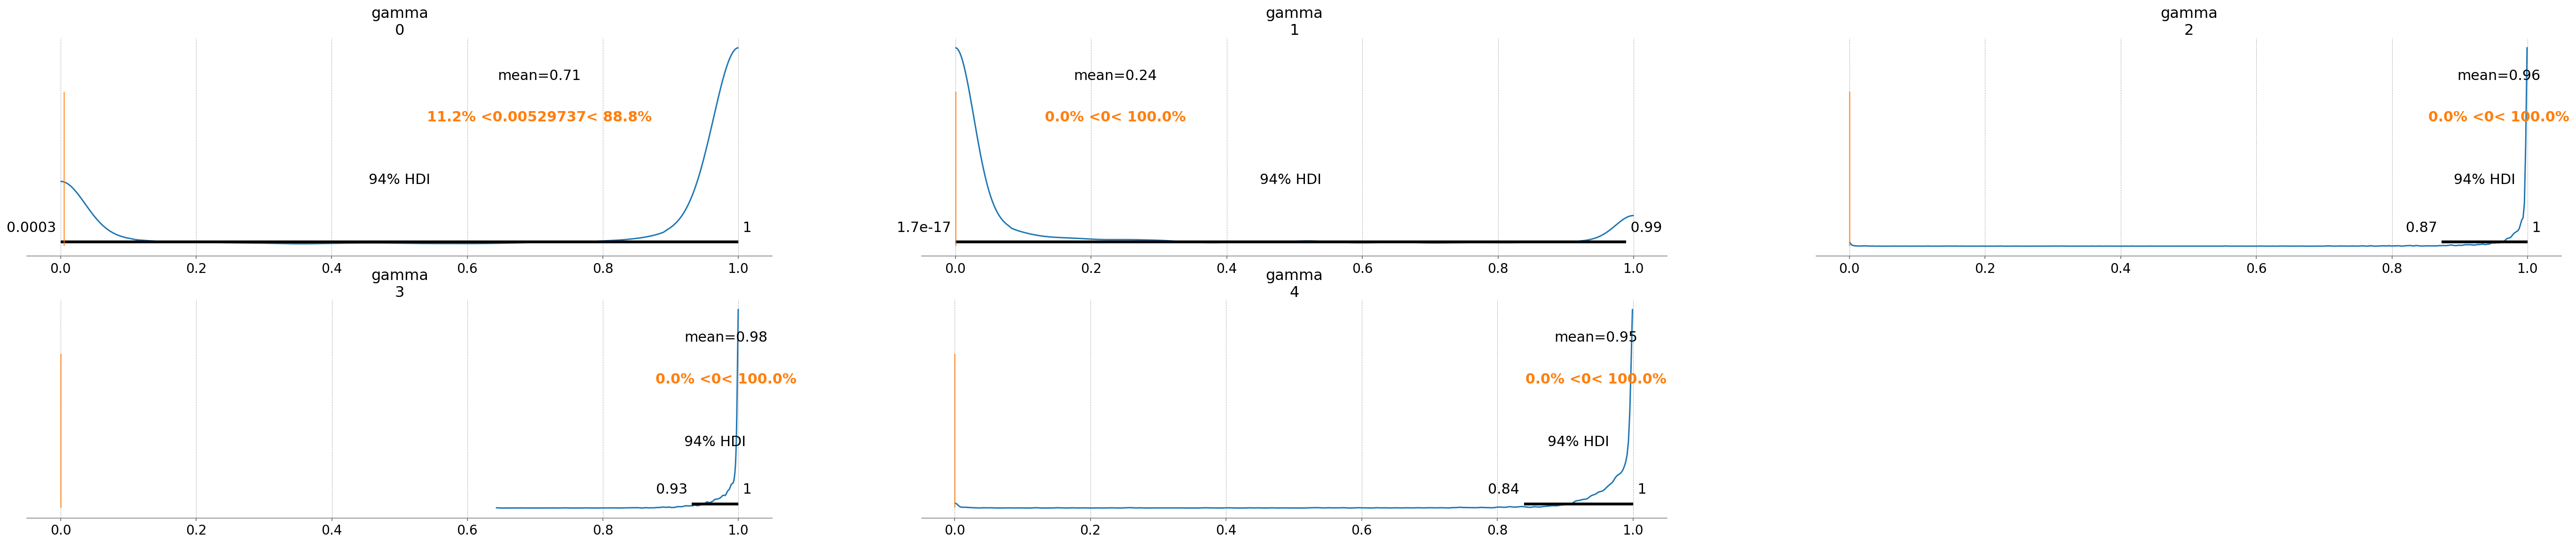

In [84]:
axes = az.plot_posterior(idata, var_names=['gamma'], ref_val=true_Γ.ravel().tolist())
# az.plot_posterior(priors, var_names=['gamma'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

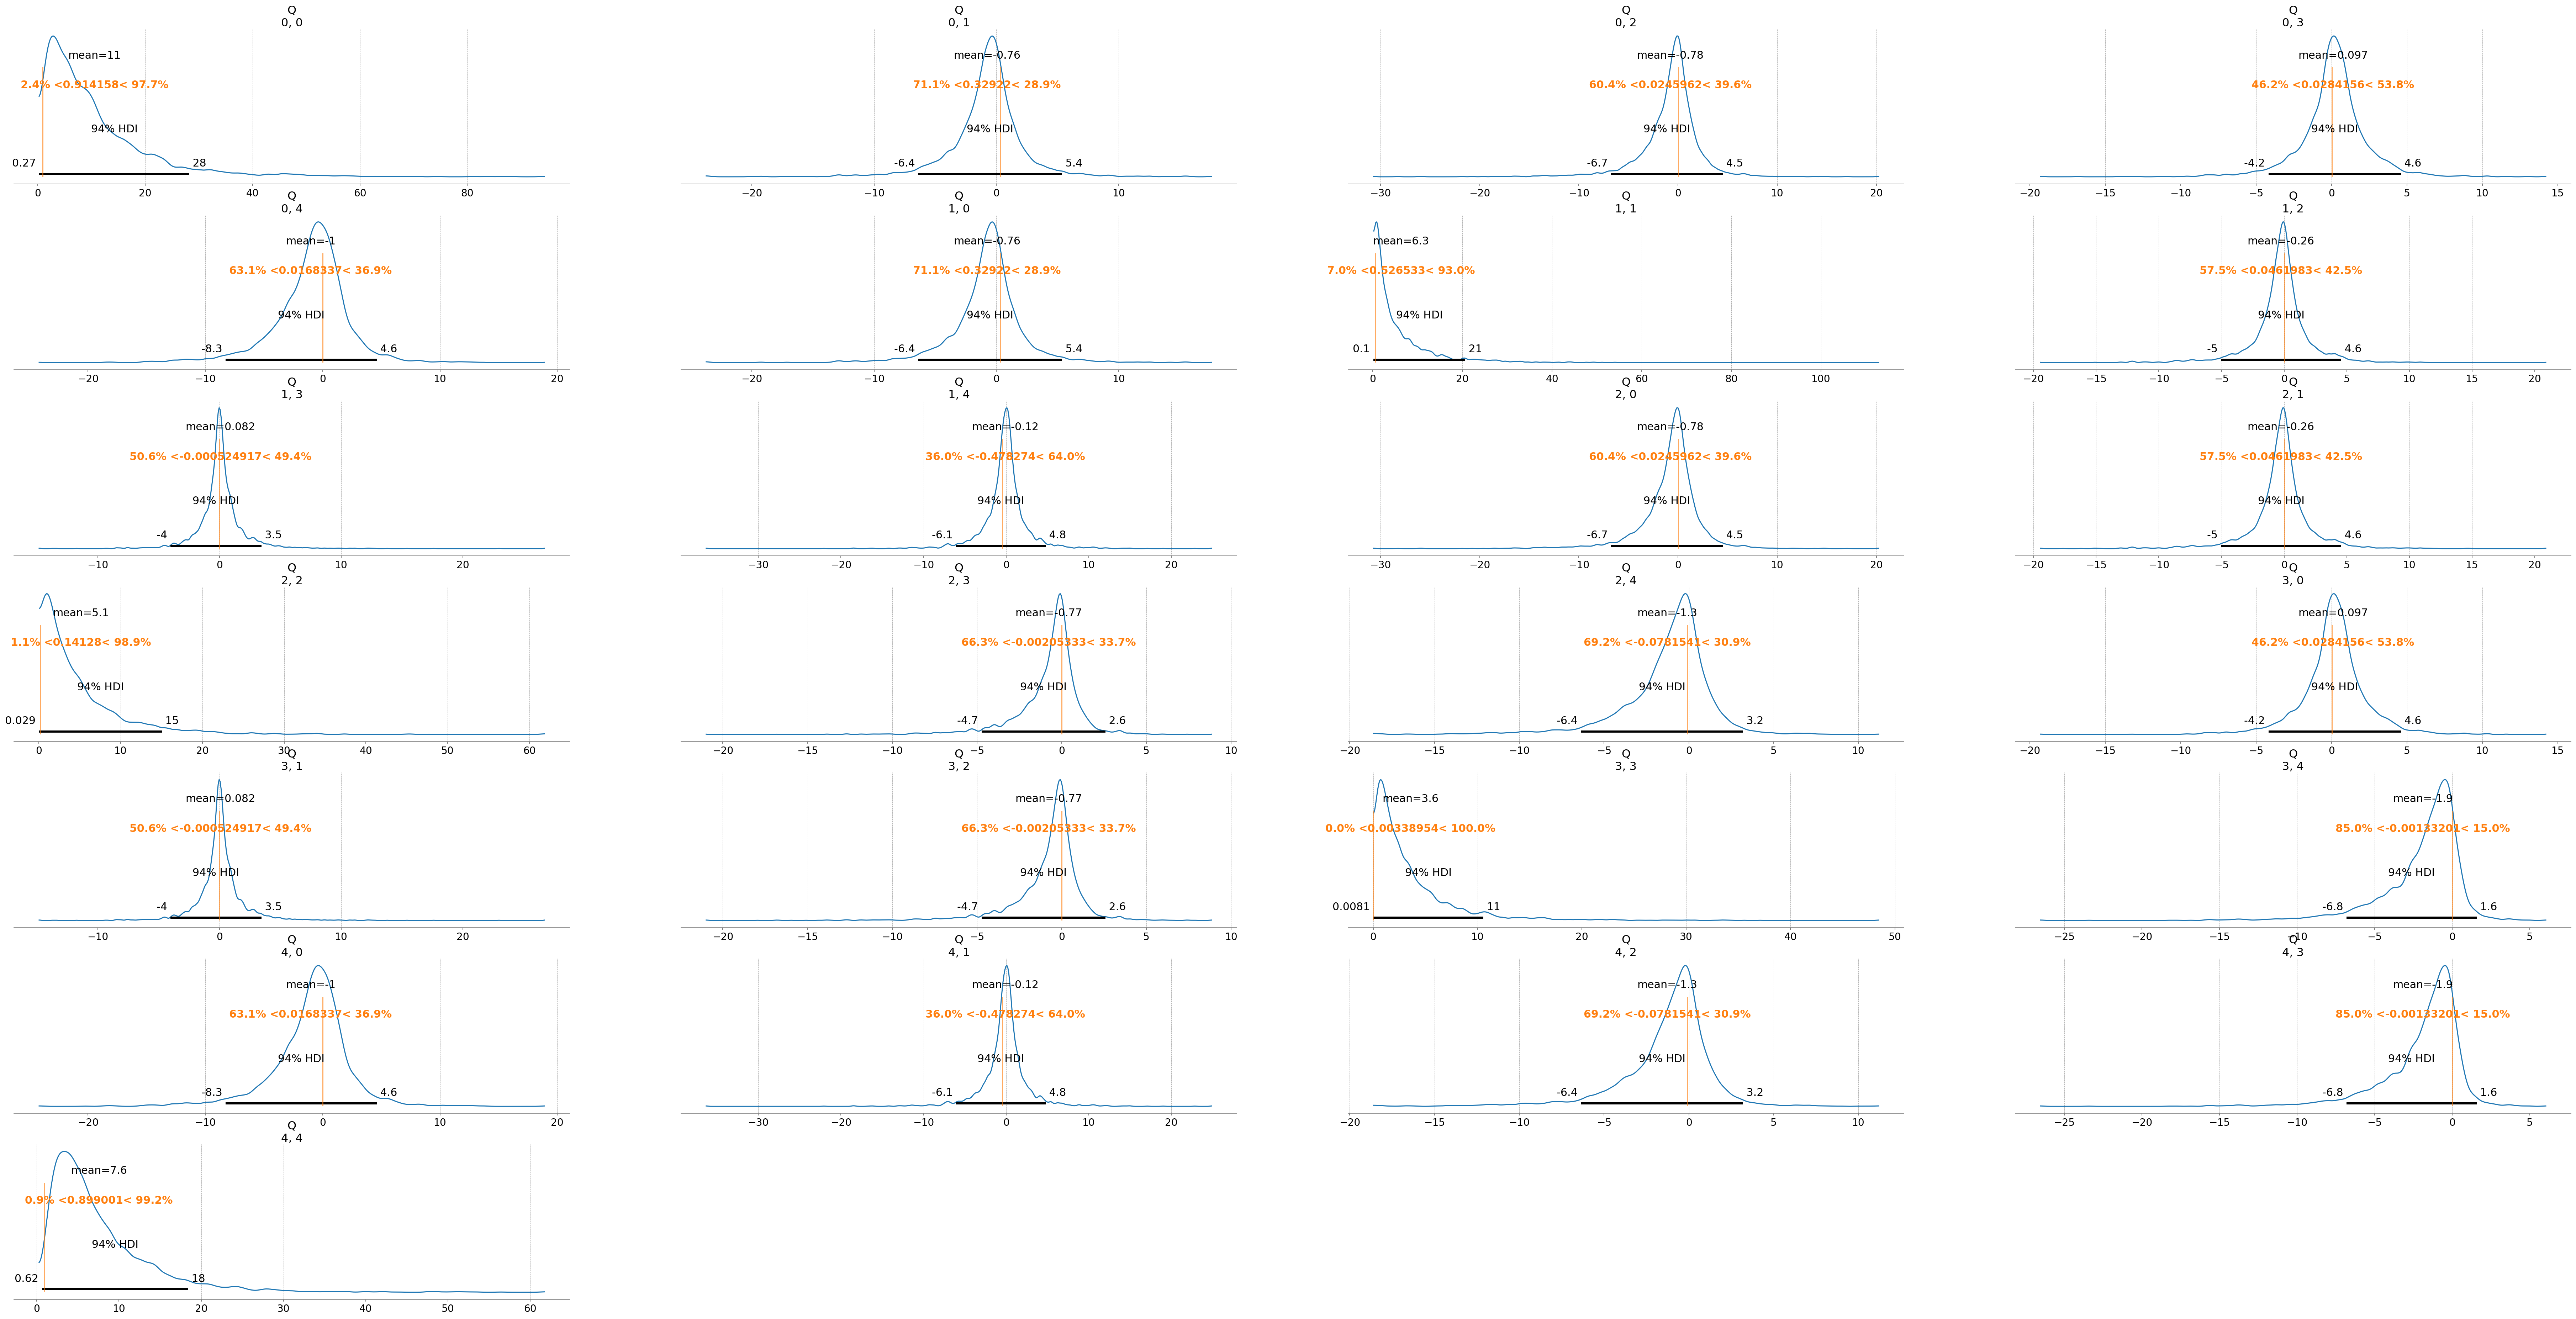

In [85]:
axes = az.plot_posterior(idata, var_names=['Q'], ref_val=true_Q.ravel().tolist())
# az.plot_posterior(priors, var_names=['Q'], group='prior', grid=(2,2), ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

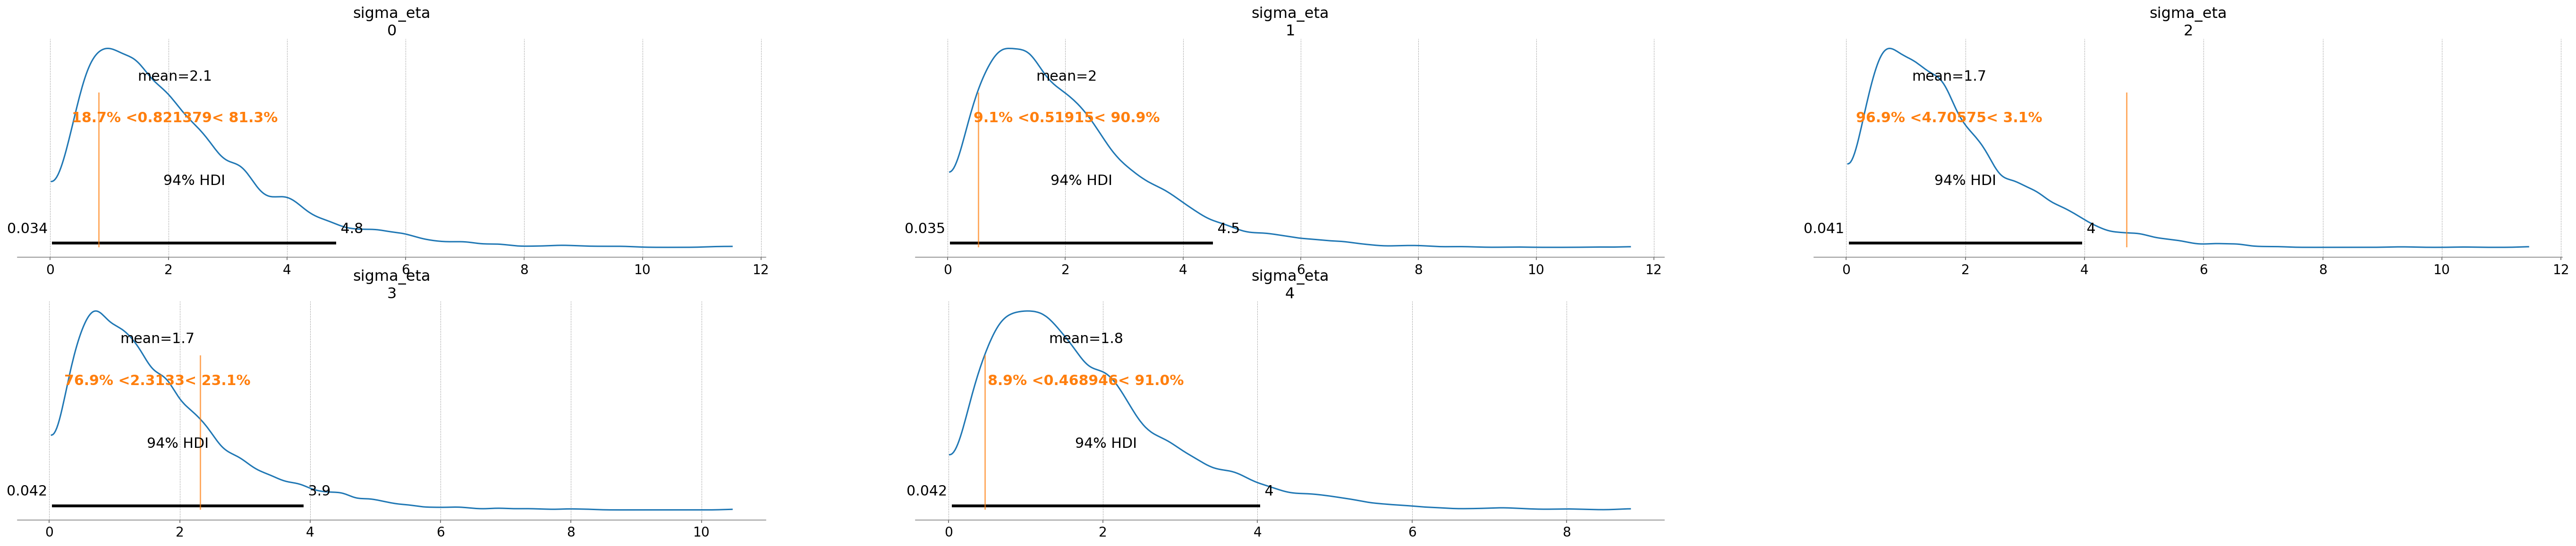

In [86]:
axes = az.plot_posterior(idata, var_names=['sigma_eta'], ref_val=np.diagonal(true_Σ).tolist())
# az.plot_posterior(priors, var_names=['sigma_eta'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

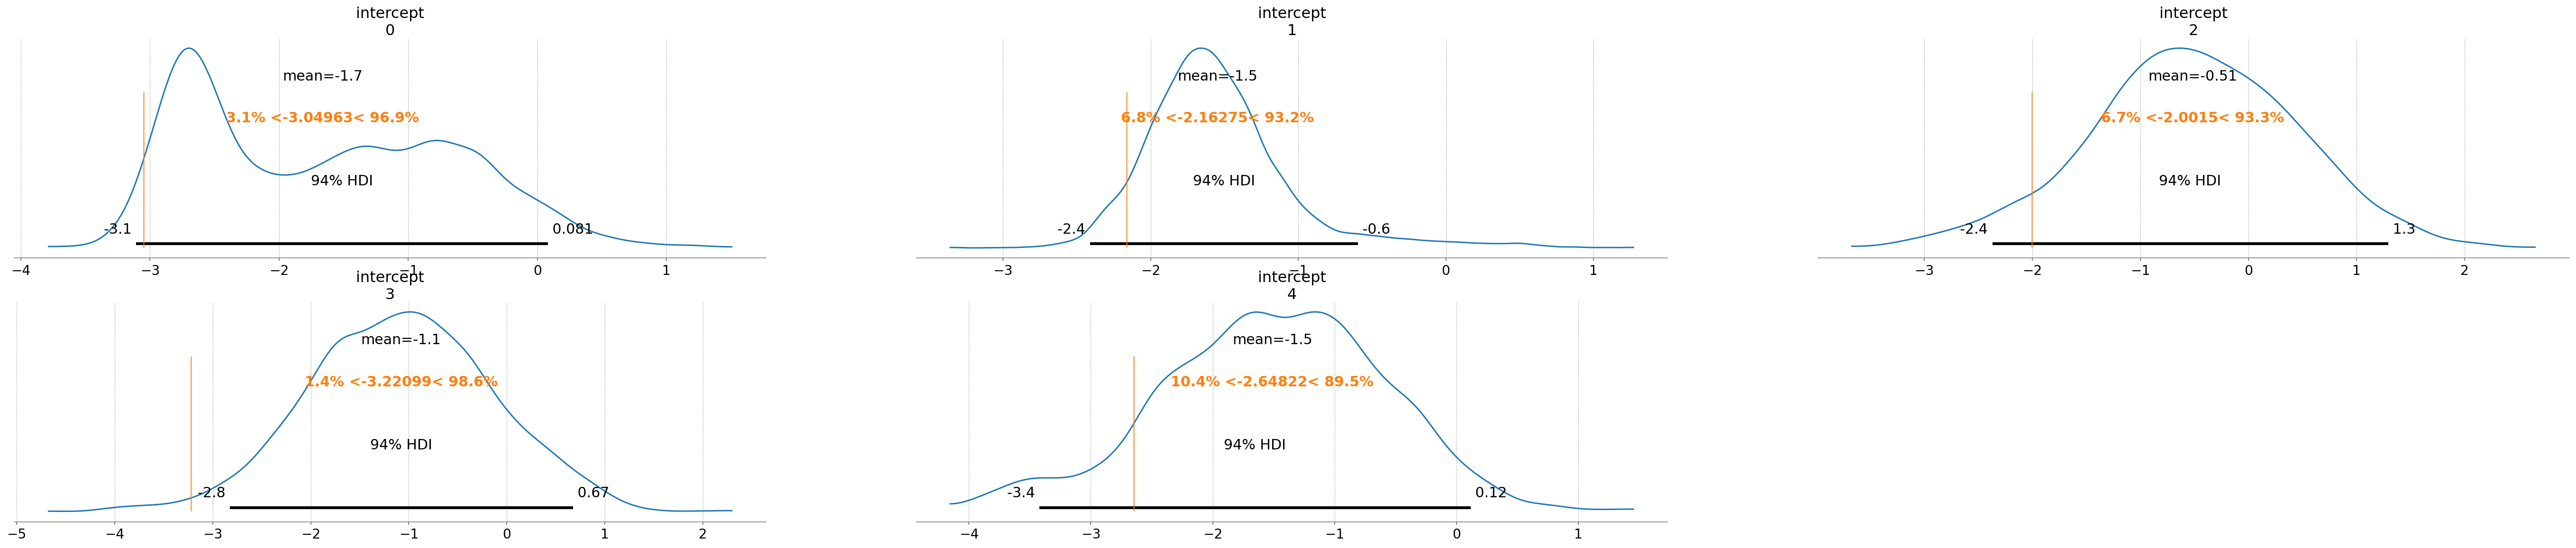

In [87]:
axes = az.plot_posterior(idata, var_names=['intercept'], ref_val=true_intercept.tolist())
# az.plot_posterior(priors, var_names=['intercept'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');